In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import talib
import yfinance as yf

In [192]:
def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    exp1 = data['Close'].ewm(span=fast_period, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [193]:
def generate_signals(stock_symbol, index_symbol, start_date, end_date):
    # Fetch stock data using yfinance
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    index_data = yf.download(index_symbol, start=start_date, end=end_date)

    # Calculate indicators
    stock_data['upper_band'], stock_data['lower_band'] = calculate_bollinger_bands(stock_data)
    stock_data['macd'], stock_data['macd_signal'] = calculate_macd(stock_data)
    stock_data['rsi'] = calculate_rsi(stock_data)

    # Initialize signal columns
    stock_data['signal'] = 0
    stock_data['chart_pattern_signal'] = 0
    stock_data['ma_signal'] = 0

    # Apply indicator-based signals
    #checking ofr previous to make sure we din't sell/buy it back then also
    stock_data.loc[(stock_data['Close'] > stock_data['upper_band']) & (stock_data['Close'].shift(1) < stock_data['upper_band'].shift(1)), 'signal'] = -1
    stock_data.loc[(stock_data['Close'] < stock_data['lower_band']) & (stock_data['Close'].shift(1) > stock_data['lower_band'].shift(1)), 'signal'] = 1
    stock_data.loc[(stock_data['macd'] > stock_data['macd_signal']) & (stock_data['macd'].shift(1) < stock_data['macd_signal'].shift(1)), 'signal'] = 1
    stock_data.loc[(stock_data['macd'] < stock_data['macd_signal']) & (stock_data['macd'].shift(1) > stock_data['macd_signal'].shift(1)), 'signal'] = -1
    stock_data.loc[stock_data['rsi'] > 70, 'signal'] = -1 #stock is overbought
    stock_data.loc[stock_data['rsi'] < 30, 'signal'] = 1  #stock is oversold

    # Apply chart pattern verification
    stock_data['chart_pattern_signal'] = 0

    # Cup and handle pattern
    cup_handle_pattern = (stock_data['High'].rolling(50).max() == stock_data['High']) & (stock_data['High'].rolling(50).max() - stock_data['Low'].rolling(50).min() > 0.2 * stock_data['High'].rolling(50).max())
    stock_data.loc[cup_handle_pattern, 'chart_pattern_signal'] = 1
    stock_data.loc[cup_handle_pattern.shift(50).fillna(False), 'chart_pattern_signal'] = -1

    # Ascending triangle pattern
    ascending_triangle_pattern = (stock_data['High'].rolling(20).max() == stock_data['High']) & (stock_data['High'].rolling(20).max() - stock_data['Low'].rolling(20).min() > 0.1 * stock_data['High'].rolling(20).max()) & (((stock_data['Low'].diff() > 0) | (stock_data['Low'] >= stock_data['Low'].shift(1) * 0.1)).rolling(window=20).sum() >= 20)

    stock_data.loc[ascending_triangle_pattern, 'chart_pattern_signal'] = 1
    stock_data.loc[ascending_triangle_pattern.shift(20).fillna(False), 'chart_pattern_signal'] = -1

    # Descending triangle pattern
    descending_triangle_pattern = (stock_data['High'].rolling(20).max() == stock_data['High']) & (stock_data['Low'].rolling(20).min() == stock_data['Low']) & (stock_data['High'].rolling(20).max() - stock_data['Low'].rolling(20).min() > 0.1 * stock_data['High'].rolling(20).max())
    stock_data.loc[descending_triangle_pattern, 'chart_pattern_signal'] = -1
    stock_data.loc[descending_triangle_pattern.shift(20).fillna(False), 'chart_pattern_signal'] = 1

    # Head and shoulders pattern
    # head_shoulders_pattern = (stock_data['High'].shift(1) > stock_data['High']) & (stock_data['High'].shift(1) > stock_data['High']) & (stock_data['High'].shift(2) > stock_data['High'])
    # stock_data.loc[head_shoulders_pattern, 'chart_pattern_signal'] = -1
    # stock_data.loc[head_shoulders_pattern.shift(2).fillna(False), 'chart_pattern_signal'] = 1

    # Calculate moving averages
    stock_data['ma_short'] = stock_data['Close'].rolling(window=20).mean()
    stock_data['ma_mid'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['ma_long'] = stock_data['Close'].rolling(window=200).mean()

    # Apply moving average signals
    stock_data.loc[(stock_data['ma_short'] > stock_data['ma_mid']) & (stock_data['ma_mid'] > stock_data['ma_long']), 'ma_signal'] = 1
    stock_data.loc[(stock_data['ma_short'] < stock_data['ma_mid']) & (stock_data['ma_mid'] < stock_data['ma_long']), 'ma_signal'] = -1

    # Apply index opinion
    index_opinion = np.sign(index_data['Close'].pct_change().rolling(window=20).sum())
    index_opinion = pd.DataFrame(index_opinion, columns=['index_signal'])
    stock_data = stock_data.join(index_opinion)
    stock_data['index_signal'].fillna(0, inplace=True)

    # Combine all signals
    stock_data['final_signal'] = stock_data['signal'] + stock_data['chart_pattern_signal'] + stock_data['ma_signal'] + stock_data['index_signal']

    stock_data['profit'] = 0

    stock_data['Returns'] = stock_data['Close'].pct_change()
    signals=stock_data['final_signal'].values
    strategy_returns = stock_data['Returns'].values * np.roll(signals, 1)
    stock_data['StrategyReturns'] = strategy_returns

    # print(ascending_triangle_pattern.sum())
    # print(stock_data['final_signal'])
    # print(strategy_returns)
    return stock_data


In [194]:
# Defining the stock symbol, index symbol, and date range
stock_symbol = 'RELIANCE.NS'
index_symbol = '^NSEI'

stock_symbol = 'AAPL'
index_symbol = '^IXIC'

# stock_symbol = 'GOOGL'
# index_symbol = '^IXIC'

start_date = '2013-01-01'
end_date = '2023-07-01'

# Generate signals
data = generate_signals(stock_symbol, index_symbol, start_date, end_date)




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [195]:
#Calculating Cumulative Returns
data['CumulativeReturns'] = 1
data['CumulativeReturns'] = data['CumulativeReturns'] * (1 + data['StrategyReturns']).cumprod()
print("Cumulative Returns:", data['CumulativeReturns'].iloc[-1])

Cumulative Returns: 1.9624600878551834


In [196]:
def maximumdailydrawdownratio(df):

    Roll_Max = df['Adj Close'].cummax()
    Daily_Drawdown = df['Adj Close']/Roll_Max - 1.0

    Max_Daily_Drawdown = Daily_Drawdown.cummin()

    #Plot the results
    print("Maximum Drawdown:")
    print(Max_Daily_Drawdown.min())
    avg_drawdown = Max_Daily_Drawdown.mean()
    print("Average Drawdown:", avg_drawdown)
    Daily_Drawdown.plot(color='violet')
    Max_Daily_Drawdown.plot(color='blue')
    plt.ylabel('Maximum_Daily_Drawdown_Ratio')
    plt.title('Reliance')
    plt.show()
    return  Max_Daily_Drawdown

Maximum Drawdown:
-0.3851589749883191
Average Drawdown: -0.3302159419350888


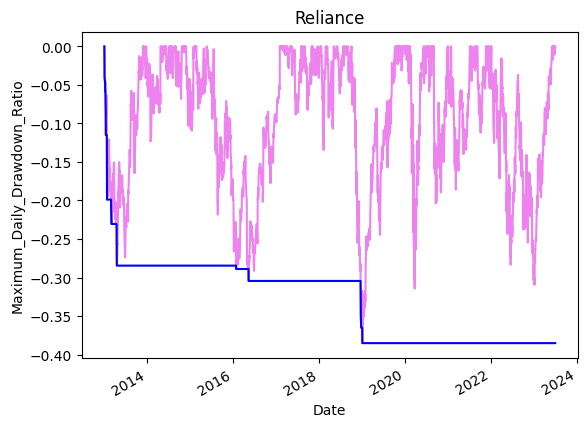

In [197]:
# Calculating Maximum Drawdown ratio
data['New_DrawDown']=maximumdailydrawdownratio(data)



In [198]:
def risk_free_daily(rate):
  risk_free_rate=rate  #considered annual return rate of 3.5% for all the stocks and indices
  Number_of_compounding_periods_per_year=252
  risk_free = (1 + risk_free_rate)** (1 / Number_of_compounding_periods_per_year) - 1
  return risk_free

In [199]:
#Sharpe ratio
daily_returns = data['StrategyReturns'].dropna()

risk_free_rate = 0.035
while risk_free_rate <= 0.06:
    risk_free = risk_free_daily(risk_free_rate)
    sharpe_ratio = (daily_returns.mean() - risk_free) / daily_returns.std()
    print(f"Sharpe Ratio for {risk_free_rate:.3f} is {sharpe_ratio:.6f} and Annual Sharpe ratio is {sharpe_ratio * (252 ** 0.5):.6f}")
    risk_free_rate += 0.005


Sharpe Ratio for 0.035 is 0.015418 and Annual Sharpe ratio is 0.244746
Sharpe Ratio for 0.040 is 0.014209 and Annual Sharpe ratio is 0.225564
Sharpe Ratio for 0.045 is 0.013007 and Annual Sharpe ratio is 0.206474
Sharpe Ratio for 0.050 is 0.011810 and Annual Sharpe ratio is 0.187475
Sharpe Ratio for 0.055 is 0.010619 and Annual Sharpe ratio is 0.168566
Sharpe Ratio for 0.060 is 0.009433 and Annual Sharpe ratio is 0.149745


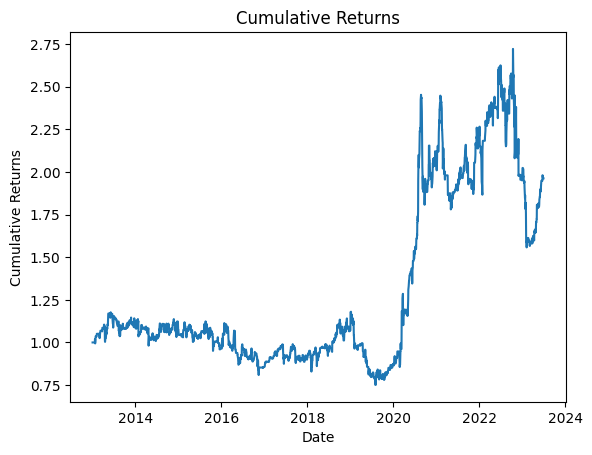

In [200]:
# Plotting Cumulative Returns
plt.plot(data.index, data['CumulativeReturns'])
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()
